<a href="https://colab.research.google.com/github/kamnsv/ai-theory/blob/main/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D0%BF%D1%80%D0%B5%D0%BE%D0%BF%D0%B4%D0%B0%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D0%B5%D0%B9_%D0%9D%D0%9D%D0%93%D0%A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Постановка задачи

В рамках данного исследования поставлена задача классификации преподавателей по направлениям их деятельности, соответствующим факультетам ННГУ. Классификация будет осуществляться по следующим факультетам:

1. Институт информационных технологий, математики и механики
0. Институт биологии и биомедицины
0. Факультет социальных наук
0. Экономический факультет
0. Радиофизический факультет
0. Факультет культуры и спорта
0. Высшая школа искусств и дизайна
0. Высшая школа общей и прикладной физики
0. Институт клинической медицины
0. Институт международных отношений и мировой истории
0. Институт филологии и журналистики
0. Физический факультет
0. Химический факультет
0. Юридический факультет

Идея заключается в том, чтобы выявить пересечения между различными направлениями деятельности преподавателей и обучить классификатор, который в перспективе сможет помочь абитуриентам подобрать направление обучения в зависимости от их предпочтений.

Для достижения этой цели будут собраны данные о преподавателях, включая их образование, преподаваемые дисциплины и научные публикации. Затем данные будут обработаны, а пропуски в информации будут устранены путем удаления записей с неполными данными.

В качестве метода обработки текстовых данных будет использоваться предобученный трансформер BERT, что позволит эффективно извлекать значимые признаки из текстовой информации.

После этого будут обучены несколько классических моделей машинного обучения, таких как kNN, SVM, решающие деревья, случайный лес и градиентный бустинг. Для оценки качества моделей будут рассчитаны метрики, такие как accuracy, ROC AUC, PR AUC, precision, recall и F1-score.

> В результате выполнения данной задачи планируется не только классификация преподавателей по направлениям их деятельности, но и создание инструмента для поддержки абитуриентов в выборе образовательного пути на основе анализа предпочтений и интересов.

# Решение

In [1]:
#@title Библиотеки
import requests
from lxml import html
import re
import pandas as pd
import typing as T
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
import json
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_auc_score,
                             average_precision_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             precision_recall_curve,
                             roc_curve,
                             fbeta_score)
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



## Парсинг

1. Получаем общие число `total_persons` преподавателй из певой страницы.
2. Определяем общее число страниц `total_pages = int(total_persons/pre_page + 0.5)`.
3. Парсим каждого преподавателя на странице.
4. Переходим на следующую страницу.
5. Формируем эмбеддинги при помощи мультиязычного Bert.
6. Сохраняем на google disk в формате `csv`.

In [2]:
#@title Адреса
urls = {
  'ВМК': '02331',
  'БИОФАК': '02324',
  'ФСН': '00164',
  'ЭКОНОМ': '05416',
  'РФСЛФ': '00113',
  'ФКС': '00159',
  'Дизайн': '05229',
  'ВШОПФ': '00024',
  'Медицина': '05231',
  'ФМО': '01986',
  'ФИЛФАК': '02835',
  'ФИЗФАК': '00152',
  'ХИМФАК': '00169',
  'ЮРФАК': '00199'
}

url_base = 'https://person.unn.ru/?p=' # ресурс для пасинга
url_page = 'https://person.unn.ru/?page=%d&p=' # шаблон следующих страниц
url_person = 'https://person.unn.ru/%s' # шаблон страниц преподавателей
path_cache = r'/content/drive/MyDrive/ParseUNN' # путь для кэша

In [3]:
#@title HTML селекторы данных
class TemapltesParsing(T.NamedTuple):
    total_persons: str = '//span[@class="people_num"]/text()'
    named_persons: str = '//span[@class="persons_list__title"]/a/text()'
    links_persons: str = '//span[@class="persons_list__title"]/a/@href'
    name_person: str = '//h1[@class="title"]/text()'
    desc_person: str = '//div[@class="post_value"]'
    general_person: str = '//div[contains(@class, "page_1")]'
    discip_person: str = '//div[contains(@class, "page_2")]'
    public_person: str = '//div[contains(@class, "page_3")]'


In [4]:
#@title Парсинг навигации
class PasrsingNav:

  def __init__(self, first_page: str):
    t = TemapltesParsing()
    dom = html.fromstring(first_page)
    texts = dom.xpath(t.total_persons)
    assert len(texts), ('Не распасить общие число преподавателей')

    numbers = re.findall(r'\d+', texts[0])
    numbers = [int(num) for num in numbers]
    if numbers:
      self.total_persons = max(numbers)
    else:
      raise Exception('Не удалось получить кол-во преподавателей')

    texts = dom.xpath(t.named_persons)
    assert len(texts), ('Не распасить кол-во преподавателей на странице')
    self.pre_page = len(texts)
    self.total_pages = self.total_persons/self.pre_page
    if self.total_persons//self.pre_page != self.total_pages:
      self.total_pages += 1
    self.total_pages = int(self.total_pages)

In [5]:
#@title Загрузчик html-страницы
class Loader:

    path_cache = path_cache

    @classmethod
    def encode(cls, url: str) -> str:
      base = url.split('#')[0]
      return base.replace('/', '#')

    @classmethod
    def decode(cls, file_name: str) -> str:
      return file_name.replace('#', '/')

    @classmethod
    def get_cache(cls, url: str) -> str:
      fname = cls.encode(url)
      path = cls.path_cache + os.sep + fname
      if os.path.isfile(path):
        try:
          with open(path, 'r') as f:
            print(f'Получен из кэша "{path}"')
            return f.read()
        except Exception as e:
          print(f'Ошибка получения страницы "{url}" из кэша по причине: {e}')

    @classmethod
    def set_cache(cls, url: str, text: str):
      fname = cls.encode(url)
      path = cls.path_cache + os.sep + fname
      try:
        with open(path, 'w') as f:
          f.write(text)
      except Exception as e:
        print(f'Ошибка кэширования страницы "{url}" по причине: {e}')

    @classmethod
    def get(cls, url: str) -> str:
      if text := cls.get_cache(url):
        return text
      try:
        res = requests.get(url)
        text = res.text
        cls.set_cache(url, text)
        return text
      except Exception as e:
        print(f'Ошибка загрузки страницы "{url}" по причине: "{e}"')


In [6]:
#@title Структура карточки
class PersonData(T.NamedTuple):
  src: str
  link: str

  @property
  def dom(self):
    return html.fromstring(self.src)

  @property
  def name(self) -> str:
    t = TemapltesParsing()
    texts = self.dom.xpath(t.name_person)
    assert len(texts), ('Имя преподавателя не найдено')
    return texts[0]

  @property
  def place(self) -> str:
    t = TemapltesParsing()
    texts = self.dom.xpath(t.desc_person)
    if len(texts) > 0:
      return 'Место работы:' + texts[0].text_content().replace('\r\n', '').strip()
    return ''

  @property
  def degree(self) -> str:
    t = TemapltesParsing()
    texts = self.dom.xpath(t.desc_person)
    if len(texts) > 1:
      return 'Ученая степень: ' + texts[1].text_content().replace('\r\n', '').strip()
    return ''

  @property
  def academic(self) -> str:
    t = TemapltesParsing()
    texts = self.dom.xpath(t.desc_person)
    if len(texts) > 2:
      return 'Ученое звание: ' + texts[2].text_content().replace('\r\n', '').strip()
    return ''

  @property
  def general(self) -> str:
    t = TemapltesParsing()
    texts = self.dom.xpath(t.general_person)
    if len(texts) > 0:
      return texts[0].text_content().strip()
    return ''

  @property
  def discip(self) -> str:
    t = TemapltesParsing()
    texts = self.dom.xpath(t.discip_person)
    if len(texts) > 0:
      return texts[0].text_content().strip()
    return ''

  @property
  def public(self) -> str:
    t = TemapltesParsing()
    texts = self.dom.xpath(t.public_person)
    if len(texts) > 0:
      return texts[0].text_content().strip()
    return ''

  @property
  def text(self) -> str:
    return self.general + '/n' + self.degree + '/n' + self.discip + '/n' + self.public

  @property
  def data(self) -> dict:
    return {
        'general': self.general,
        'degree': self.degree,
        'discip': self.discip,
        'public': self.public,
        'academic': self.academic
    }

In [7]:
#@title Генератор html-страниц
class WalkerPages:
  def __init__(self, url_page: str, url_person):
    self.url_page = url_page
    self.url_person = url_person

  def page(self, start:int, end: int) -> T.Generator[str, None, None]:
    end += 1
    progress_bar = tqdm(desc='Processing parsing', total=(end-start), unit='page')
    for i in range(start, end):
      url = self.url_page % i
      progress_bar.set_postfix({'URL': url})
      text = Loader.get(url)
      progress_bar.update(1)
      yield text

  def persons(self, page_with_persons: str) -> T.Generator[tuple, None, None]:
    t = TemapltesParsing()
    dom = html.fromstring(page_with_persons)
    texts = dom.xpath(t.links_persons)
    assert len(texts), ('Не найдены ссылки преподавателей на странице')

    progress_bar = tqdm(desc='Processing load', total=len(texts), unit='person')
    for i in texts:
      url = self.url_person % i
      progress_bar.set_postfix({'Page': url})
      text = Loader.get(url)
      progress_bar.update(1)
      yield url, text


In [8]:
#@title Основной класс парсинга
class PasingPersonUNN:

  def __init__(self, url_base: str, url_page: str, url_person: str):
    self.url = url_base
    self.walk = WalkerPages(url_page, url_person)
    self.persons: T.List[PersonData] = []

  def generate(self, count_page: int = 0, first_page: str = '')-> T.Generator[PersonData, None, None]:
    first_page = first_page if first_page else Loader.get(self.url)
    self.nav = PasrsingNav(first_page)
    count_page = int(count_page if count_page else self.nav.total_pages)

    for person in self.parsing_persons(first_page):
        yield person

    for page in self.walk.page(2, count_page):
        for person in self.parsing_persons(page):
          yield person

  def parsing_persons(self, page: str) -> T.Generator[PersonData, None, None]:
    for url, person in self.walk.persons(page):
      yield PersonData(src=person, link=url)



In [9]:
#@title Инкоер текста
class Encoder:

  def __init__(self):
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
    self.model = AutoModel.from_pretrained("bert-base-multilingual-cased").to(self.device)


  def get_embeddings(self, sentences: T.List[str]) -> tuple:
    means = []
    maxes = []
    for sentence in sentences:
        inputs = self.tokenizer(sentence, return_tensors='pt', truncation=True, padding=True).to(self.device)
        with torch.no_grad():
            outputs = self.model(**inputs)

        # Получаем все эмбеддинги
        all_embeddings = outputs.last_hidden_state

        # Средний эмбеддинг по всем токенам
        mean_embedding = all_embeddings.mean(dim=1)

        # максимальный эмбеддинг по всем токенам
        max_embedding, _ = all_embeddings.max(dim=1)

        means.append(mean_embedding.cpu())
        maxes.append(max_embedding.cpu())
    return np.vstack(means), np.vstack(maxes)


In [10]:
#@title Процесс парсинга

encoder = Encoder()

for target, url in urls.items():
  file_save = path_cache + f'_{target}.csv'
  if os.path.isfile(file_save):
    print('Exists', file_save)
    continue

  names = []
  links = []
  #vectors = []
  data = []

  pp_unn = PasingPersonUNN(url_base+url, url_page+url, url_person)
  for person in pp_unn.generate():

    #sentences = sent_tokenize(person.text, language='russian')
    #embeddings = encoder.get_embeddings(sentences)

    if 1:
      #avg_embedding = torch.mean(torch.cat(embeddings), dim=0)
      #vectors.append(avg_embedding.numpy())
      names.append(person.name)
      links.append(person.link)
      data.append(person.data)

  #all_embeddings = np.array(vectors)
  np.save(path_cache + f'{target}__names', np.array(names))
  np.save(path_cache + f'{target}__links', np.array(links))
  #np.save(path_cache + f'{target}__vectors', all_embeddings)
  df = pd.DataFrame({'name': names,
                     'target': target,
                'link': links,
                'general': [i['general'] for i in data],
                'degree': [i['degree'][len('Ученая степень: '):].lower().strip() for i in data],
                'discip': [i['discip'][len('Список преподаваемых дисциплин'):].strip() for i in data],
                'public': [i['public'] for i in data],
                'academic': [i['academic'][len('Ученое звание:'):].lower().strip() for i in data],
                #'vectors': [json.dumps(i.tolist()) for i in vectors]
                })
  df.to_csv(path_cache + f'_{target}.csv', index=False)
  print('Save', file_save)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Exists /content/drive/MyDrive/ParseUNN_ВМК.csv
Exists /content/drive/MyDrive/ParseUNN_БИОФАК.csv
Exists /content/drive/MyDrive/ParseUNN_ФСН.csv
Exists /content/drive/MyDrive/ParseUNN_ЭКОНОМ.csv
Exists /content/drive/MyDrive/ParseUNN_РФСЛФ.csv
Exists /content/drive/MyDrive/ParseUNN_ФКС.csv
Exists /content/drive/MyDrive/ParseUNN_Дизайн.csv
Exists /content/drive/MyDrive/ParseUNN_ВШОПФ.csv
Exists /content/drive/MyDrive/ParseUNN_Медицина.csv
Exists /content/drive/MyDrive/ParseUNN_ФМО.csv
Exists /content/drive/MyDrive/ParseUNN_ФИЛФАК.csv
Exists /content/drive/MyDrive/ParseUNN_ФИЗФАК.csv
Exists /content/drive/MyDrive/ParseUNN_ХИМФАК.csv
Exists /content/drive/MyDrive/ParseUNN_ЮРФАК.csv


## Формирование выборок

In [11]:
#@title Общий датасет
dataframes = []
import glob
for target in urls:
    file_data = path_cache + f'_{target}.csv'
    df = pd.read_csv(file_data)
    dataframes.append(df)
columns = ['name', 'target', 'general', 'discip', 'public']
# Объединяем все DataFrame в один
df = pd.concat(dataframes, ignore_index=True)
df = df[columns]
df

,name,target,general,discip,public
0,Золотых Николай Юрьевич,ВМК,"Образование, учёные степени и учёные звания\n ...",NaN,Публикации2024Труды (тезисы) конференцииKarchk...
1,Абрамов Семен Сергеевич,ВМК,NaN,NaN,Публикации2022Труды (тезисы) конференцииАбрамо...
2,Аветисова Лили Алексеевна,ВМК,"Образование, учёные степени и учёные звания\n ...",NaN,NaN
3,Алфеев Дмитрий Андреевич,ВМК,"Образование, учёные степени и учёные звания\n ...",NaN,NaN
4,Аммосова Елена Петровна,ВМК,"Образование, учёные степени и учёные звания\n ...",NaN,NaN
...,...,...,...,...,...
2573,Щерова Наталья Сергеевна,ЮРФАК,"Образование, учёные степени и учёные звания\r\...",Юридический факультетИндивидуальные консультац...,Публикации2023Труды (тезисы) конференцииЩерова...
2574,Юматов Василий Алексеевич,ЮРФАК,"Образование, учёные степени и учёные звания\r\...",Юридический факультетАктуальные проблемы крими...,Публикации2024Сборники статейЮматов В.А. НАЦИО...
2575,Юматов Сергей Васильевич,ЮРФАК,"Образование, учёные степени и учёные звания\r\...",Юридический факультетДактилоскопия и дактилоск...,"Публикации2024Сборники статейПогодина Т.Г., Юм..."
2576,Юргель Оксана Николаевна,ЮРФАК,"Образование, учёные степени и учёные звания\r\...",Юридический факультетГражданский процесс Особ...,"Публикации2023Сборники статейБалдин А.К., Юрге..."


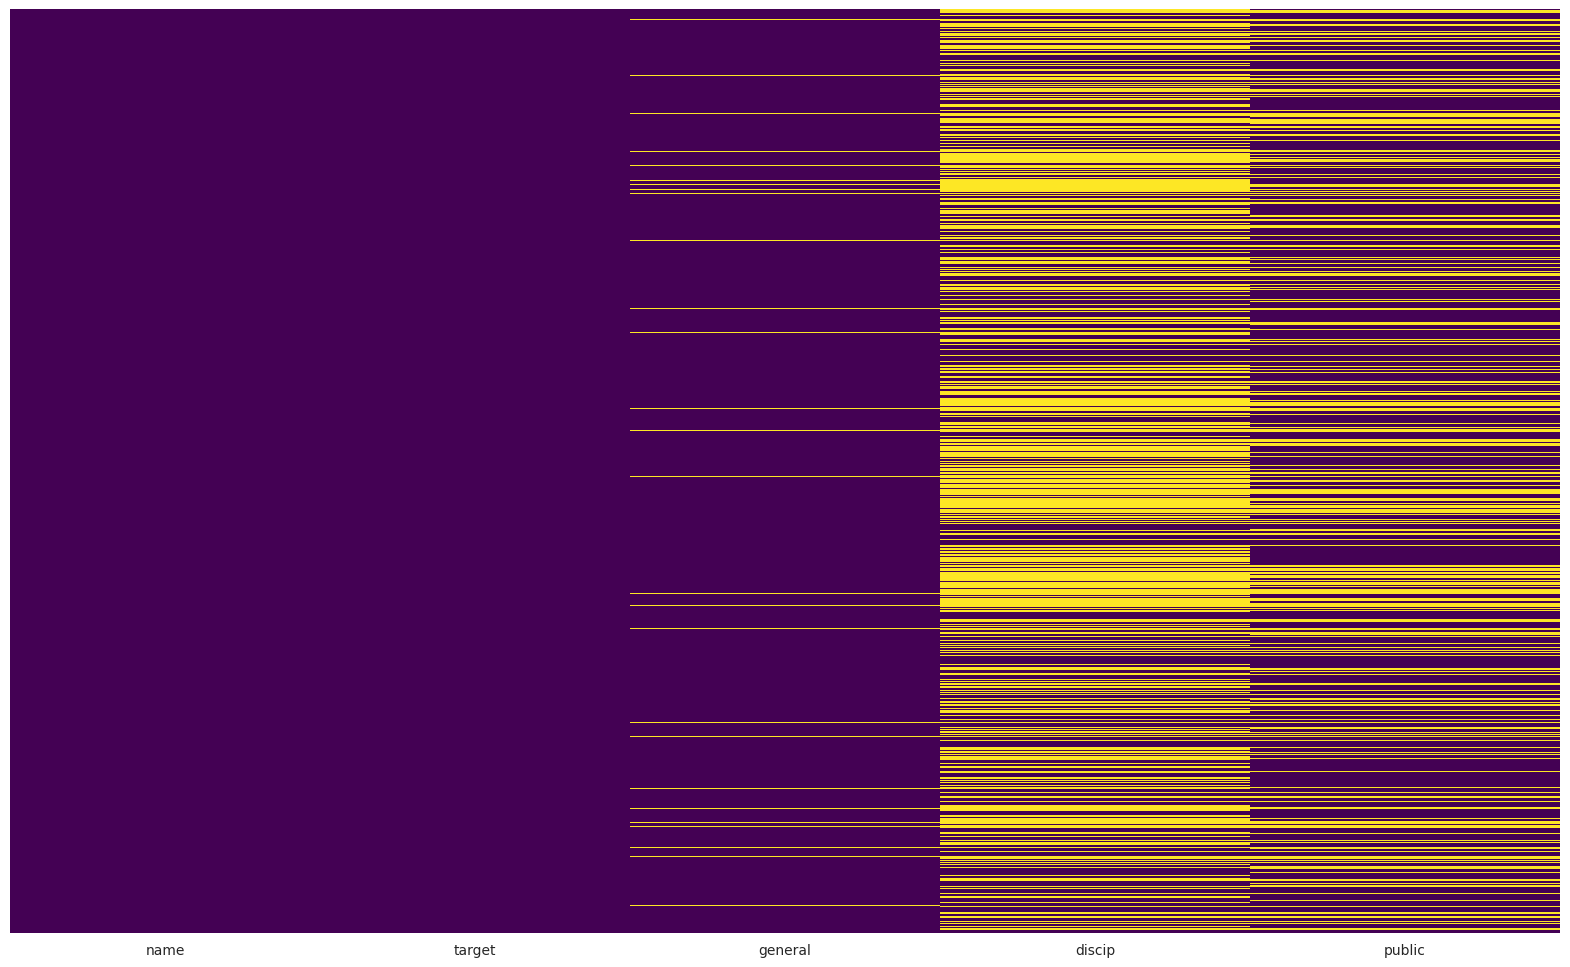

Процент пропущенных данных 27.5537%


In [12]:
#@title Обзор пропусков
plt.figure(figsize=(20,12)) # Создаем область под график
sns.heatmap(df.isnull(), yticklabels=False,
                          cbar=False, cmap='viridis') # Визуализируем пропуски
plt.show() # Отображаем график
print('Процент пропущенных данных {:.4f}%'.format(sum(df[columns[2:]].isnull().mean() * 100)/3))

In [13]:
#@Обработка пропусков

#@markdown В финальную выборку войдут колонки:
#@markdown - образование (general)
#@markdown - дисциплины(discip)
#@markdown - публикации (public)

#@markdown Если какое то из полей имеет пропуск то заменяется пустой строкой, если пропущены все данные, то преподаватель удаляется.
df.fillna('', inplace=True)
df = df[(df[['general', 'discip', 'public']] != '').any(axis=1)]
len(df)

2507

In [14]:
#@title Статистика по таблице
def table_state(data):
    inf=("Фича", "тип", "Пустых","НЕпустые", "Уникальных", "min", "max", "Пример")
    table = pd.DataFrame(columns=inf)
    count = len(data)
    for i, col in enumerate(data):
      na = data[col].isna().sum() # кол-во пустых
      name = f'{i+1} {col}, {data[col].dtypes}'      # единицы из группы
      row = {
            "Фича":        col,
            "тип":         data[col].dtypes,
            "Пустых":      na,
            "НЕпустые":    count - na,
            "Уникальных":  data[col].nunique(),
            "min":         '' if 'object' ==  data[col].dtypes else data[col].min(),
            "max":         '' if 'object' ==  data[col].dtypes else data[col].max(),
            "Пример":      data[col].unique()[:3],
      }
      table = pd.concat([table, pd.DataFrame([row])], ignore_index=True)
    pd.set_option('display.max_rows',  count)
    return table

table_state(df)

,Фича,тип,Пустых,НЕпустые,Уникальных,min,max,Пример
0,name,object,0,2507,2461,,,"[Золотых Николай Юрьевич, Абрамов Семен Сергее..."
1,target,object,0,2507,14,,,"[ВМК, БИОФАК, ФСН]"
2,general,object,0,2507,2307,,,"[Образование, учёные степени и учёные звания\n..."
3,discip,object,0,2507,1243,,,"[, Институт информационных технологий, математ..."
4,public,object,0,2507,1801,,,[Публикации2024Труды (тезисы) конференцииKarch...


In [15]:
#@title Удаление дубликатов
#@markdown Те преподавателт, которые числятся на нескольких факультат, подлежат удалению
index_drop = df.groupby('name').filter(lambda x: len(x) > 1).index
print('Удалим', len(index_drop), 'записей')
df = df.drop(index=index_drop)
len(df)

Удалим 92 записей


2415

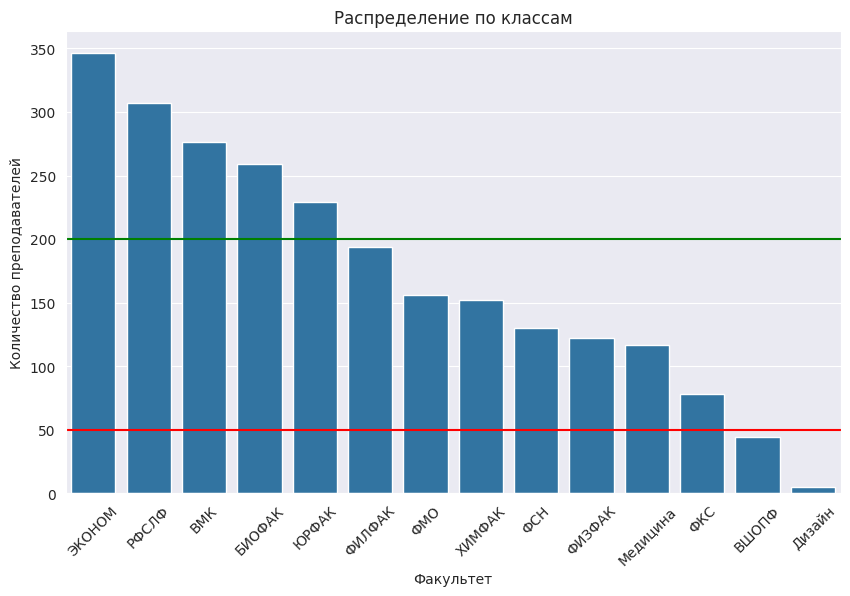

In [16]:
#@title Баланс классов
value_counts = df.target.value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.xlabel('Факультет')
plt.ylabel('Количество преподавателей')
plt.axhline(50, label='Малое число эксземпляров', c='r')
plt.axhline(200, label='Большое число эксземпляров', c='g')
plt.title('Распределение по классам')
plt.xticks(rotation=45)
plt.show()

In [17]:
#@title Соотношение классов
'/'.join([str(i) for i in value_counts.values])

'346/307/276/259/229/194/156/152/130/122/117/78/44/5'

In [18]:
#@tiеle Удаление классов
df = df[~df.target.isin(['ВШОПФ', 'Дизайн'])]
len(df)

2366

In [19]:
#@title Уменьшение выборки
df = df.groupby('target').apply(lambda x: x.sample(n=200, random_state=42) if len(x) >= 200 else x)

# Сброс индексов после группировки
df = df.reset_index(drop=True)

len(df)

<ipython-input-19-efddd9e56acb>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('target').apply(lambda x: x.sample(n=200, random_state=42) if len(x) >= 200 else x)


1949

In [20]:
#@title Кодирование классов

# Инициализация OneHotEncoder
ohe_encoder = OneHotEncoder(handle_unknown='ignore')

# Применение One-Hot Encoding к столбцу target
y_data = ohe_encoder.fit_transform(df[['target']]).toarray()

print(y_data.shape)
ohe_encoder.categories_

(1949, 12)


[array(['БИОФАК', 'ВМК', 'Медицина', 'РФСЛФ', 'ФИЗФАК', 'ФИЛФАК', 'ФКС',
        'ФМО', 'ФСН', 'ХИМФАК', 'ЭКОНОМ', 'ЮРФАК'], dtype=object)]

In [21]:
#@title Токенизация текстов
text = df.general + ' ' + df.discip + ' ' + df.public

def clean_text(text):
  # Удаляем специальные символы
  cleaned_text = re.sub(r'[^\w\s]', ' ', text)

  # Удаляем все числа
  cleaned_text = re.sub(r'\d+', ' ', cleaned_text)

  # Разбиваем слова по заглавным буквам
  words = re.sub(r'(?<!^)(?=[А-Я])(?!(?:[А-Я]{2,}))', ' ', cleaned_text).split()

  return ' '.join([i.lower().strip() for i in words])

cleaned_text = text.apply(clean_text)
cleaned_text[0]

'образование учёные степени и учёные звания высшее образование специалитет магистратура специальность лечебное дело квалификация врач дополнительное образование повышение квалификации стажировки повышение квалификации электронная информационно образовательная среда вуза фгао у в о национальный исследовательский нижегородский государственный университет им н и лобачевского час документ рег от повышение квалификации оказание первой помощи фгбо у в о приволжский исследовательский медицинский университет министерства здравоохранения час документ рег от повышение квалификации педагогика и психология высшей школы в медицинском вузе фгбо у в о приволжский исследовательский медицинский университет министерства здравоохранения час документ рег от повышение квалификации организация образовательного процесса для обучения лиц с ограниченными возможностями здоровья и инвалидностью фгбо у в о рязанский государственный медицинский университет имени академика и п павлова министерства здравоохранения р

In [22]:
#@title Создание эмбеддингов
encoder = Encoder()
x_data = []
n = len(cleaned_text)
for i, text in enumerate(cleaned_text):
  sentences = sent_tokenize(text, language='russian')
  print(i+1,'/',n, text, end='\r')
  embeddings = encoder.get_embeddings(sentences)
  x_data.append(embeddings)

x_data = np.array(x_data).squeeze()
x_data.shape

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


(1949, 2, 768)

In [23]:
#@title Сохранение датасета
np.save(path_cache + os.sep + 'x_data', x_data)
np.save(path_cache + os.sep + 'y_data', y_data)

## Классификация

In [24]:
#@title Загрузка датасета
x_data = np.load(path_cache + os.sep + 'x_data.npy')
y_data = np.load(path_cache + os.sep + 'y_data.npy')
x_data.shape, y_data.shape

((1949, 2, 768), (1949, 12))

In [25]:
#@title Снижение размерности
tsne_mean = TSNE(n_components=2)
x_tsne_mean = tsne_mean.fit_transform(x_data[:,0,:])
df['component_1_mean'] = x_tsne_mean[:,0]
df['component_2_mean'] = x_tsne_mean[:,1]

tsne_max = TSNE(n_components=2)
x_tsne_max = tsne_max.fit_transform(x_data[:,1,:])
df['component_1_max'] = x_tsne_max[:,0]
df['component_2_max'] = x_tsne_max[:,1]

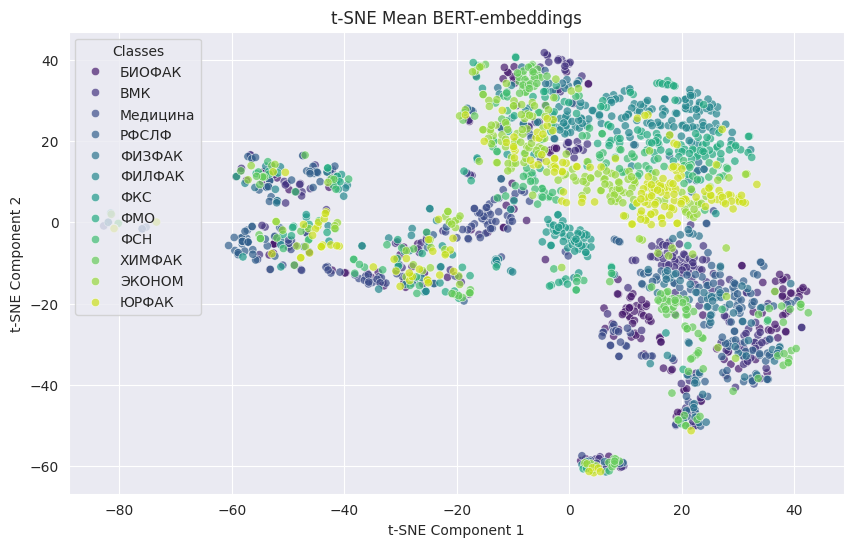

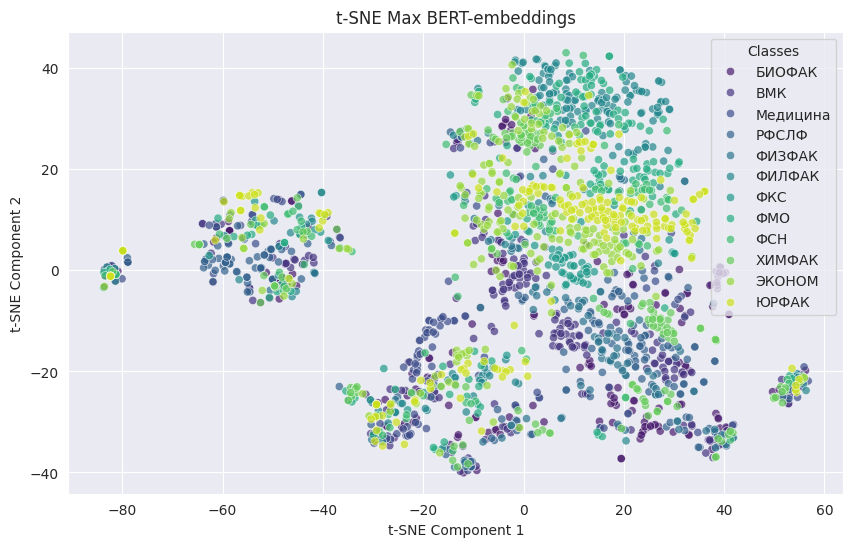

In [26]:
#@title Визуализация кластеров
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='component_1_mean', y='component_2_mean',
                hue='target', palette='viridis', alpha=0.7)
plt.title('t-SNE Mean BERT-embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Classes')
plt.show()
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='component_1_max', y='component_2_max',
                hue='target', palette='viridis', alpha=0.7)
plt.title('t-SNE Max BERT-embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Classes')
plt.show()

Анализ t-SNE показывает, что данные формируют  агломерации, где элементы одного класса сгруппированы вместе. Это свидетельствует о наличии хорошо различимых признаков, которые могут быть эффективно использованы для классификации. Наличие таких скоплений указывает на потенциально высокую точность модели классификации, так как четкие разделения между классами облегчают задачу алгоритмов машинного обучения по их различению.

In [27]:
#@title Деление на выборки
j = 0
while True:
  #@markdown Деление на тренеровочный и тестовый наборы в соотношении 70% на 30%
  x_train, x_test, y_train, y_test = train_test_split(x_data.reshape(len(x_data), -1),
                                                      y_data,
                                                      test_size=0.3,
                                                      random_state=j)
  j+=1
  y_num = np.argmax(y_train, axis=1)
  y_tnum = np.argmax(y_test, axis=1)
  if len(np.unique(y_num)) == len(np.unique(y_tnum)):
    break

j, x_train.shape, x_test.shape, y_train.shape, y_test.shape, np.unique(y_num, return_counts=True),np.unique(y_tnum, return_counts=True)


(1,
 (1364, 1536),
 (585, 1536),
 (1364, 12),
 (585, 12),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
  array([136, 138,  79, 139,  89, 144,  55, 110,  85, 104, 151, 134])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
  array([64, 62, 38, 61, 33, 50, 23, 46, 45, 48, 49, 66])))

In [28]:
#@title Расчет весов для классов
y_num = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_num), y=y_num)
class_weight_dict = dict(enumerate(class_weights))
# Создание массива весов для каждого образца
sample_weights = np.array([class_weight_dict[class_label] for class_label in y_num])
class_weights

array([0.83578431, 0.8236715 , 1.43881857, 0.8177458 , 1.27715356,
       0.78935185, 2.06666667, 1.03333333, 1.3372549 , 1.09294872,
       0.75275938, 0.84825871])

In [29]:
#@title Балансирование классов
# Увеличение выборки с помощью SMOTE
# Проверка форм данных
print("Форма X_train:", x_train.shape)
print("Форма y_train:", y_num.shape)

# Применение SMOTE
smote = SMOTE(random_state=42, k_neighbors=2)
x_smote, y_smote = smote.fit_resample(x_train, y_num)

# Проверка форм после SMOTE
print("Форма X_smote:", x_smote.shape)
print("Форма y_smote:", y_smote.shape)

Форма X_train: (1364, 1536)
Форма y_train: (1364,)
Форма X_smote: (1812, 1536)
Форма y_smote: (1812,)


In [30]:
#@title Отчет классификатора
def report(y_test, y_pred):
  print(classification_report(y_test, y_pred, target_names=ohe_encoder.categories_[0].tolist()))

Лучшее число соседий: 3
              precision    recall  f1-score   support

      БИОФАК       0.65      0.73      0.69       151
         ВМК       0.77      0.80      0.79       151
    Медицина       0.76      0.95      0.84       151
       РФСЛФ       0.88      0.68      0.77       151
      ФИЗФАК       0.71      0.92      0.80       151
      ФИЛФАК       0.91      0.70      0.79       151
         ФКС       0.78      0.99      0.87       151
         ФМО       0.78      0.84      0.81       151
         ФСН       0.64      0.93      0.75       151
      ХИМФАК       0.88      0.88      0.88       151
      ЭКОНОМ       0.91      0.13      0.23       151
       ЮРФАК       0.91      0.71      0.80       151

    accuracy                           0.77      1812
   macro avg       0.80      0.77      0.75      1812
weighted avg       0.80      0.77      0.75      1812



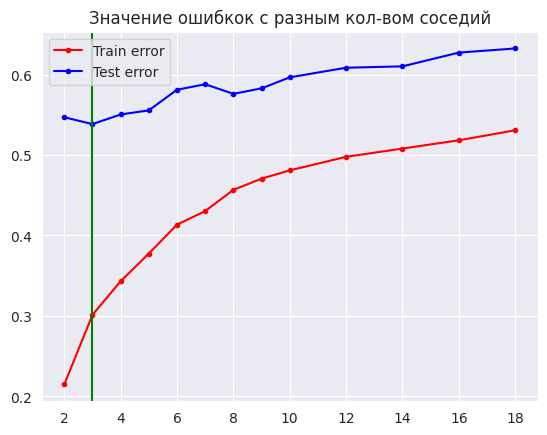

In [31]:
#@title kNN
y_tnum = np.argmax(y_test, axis=1)

kk = list(range(2, 11)) + list(range(12, 20, 2))
err_train = []
err_test = []
knns = {}
for k in kk:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(x_smote, y_smote)
    knns[k] = model
    err_train.append(np.mean(model.predict(x_train) != y_num))
    err_test.append(np.mean(model.predict(x_test) != y_tnum))

knn_best = kk[np.argmin(np.array(err_test))]
print('Лучшее число соседий:', knn_best)
report(y_smote, knns[knn_best].predict(x_smote))

plt.title('Значение ошибкок с разным кол-вом соседий')
plt.plot(kk, err_train, '.-r', label = 'Train error')
plt.plot(kk, err_test,  '.-b', label = 'Test error')
plt.axvline(knn_best, c='g')
plt.legend(loc = 2)
pass

In [32]:
#@title SVM
svc_model = SVC(kernel='linear', class_weight='balanced')
svc_model.fit(x_train, y_num)
y_pred_svm = svc_model.predict(x_test)

# Оценка модели
report(np.argmax(y_test, axis=1), y_pred_svm)

              precision    recall  f1-score   support

      БИОФАК       0.68      0.73      0.71        64
         ВМК       0.71      0.79      0.75        62
    Медицина       0.73      0.71      0.72        38
       РФСЛФ       0.80      0.74      0.77        61
      ФИЗФАК       0.61      0.70      0.65        33
      ФИЛФАК       0.79      0.82      0.80        50
         ФКС       0.58      0.61      0.60        23
         ФМО       0.77      0.72      0.74        46
         ФСН       0.78      0.69      0.73        45
      ХИМФАК       0.89      0.71      0.79        48
      ЭКОНОМ       0.57      0.67      0.62        49
       ЮРФАК       0.84      0.77      0.80        66

    accuracy                           0.73       585
   macro avg       0.73      0.72      0.72       585
weighted avg       0.74      0.73      0.73       585



In [33]:
#@title Решающие деревья
decision_tree = DecisionTreeClassifier(class_weight='balanced')
decision_tree.fit(x_train, y_train)

# Прогнозирование и оценка модели
y_pred_tree = decision_tree.predict(x_test)
report(y_test, y_pred_tree)

              precision    recall  f1-score   support

      БИОФАК       0.26      0.25      0.25        64
         ВМК       0.24      0.26      0.25        62
    Медицина       0.30      0.21      0.25        38
       РФСЛФ       0.35      0.36      0.36        61
      ФИЗФАК       0.19      0.21      0.20        33
      ФИЛФАК       0.38      0.34      0.36        50
         ФКС       0.38      0.35      0.36        23
         ФМО       0.40      0.35      0.37        46
         ФСН       0.31      0.31      0.31        45
      ХИМФАК       0.41      0.46      0.43        48
      ЭКОНОМ       0.27      0.39      0.32        49
       ЮРФАК       0.43      0.30      0.36        66

   micro avg       0.32      0.32      0.32       585
   macro avg       0.33      0.32      0.32       585
weighted avg       0.33      0.32      0.32       585
 samples avg       0.32      0.32      0.32       585



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [34]:
#@title Cлучайный лес
# Создание и обучение модели случайного леса
random_forest = RandomForestClassifier(n_estimators=100, class_weight='balanced')
random_forest.fit(x_train, y_train)

# Прогнозирование и оценка модели
y_pred_forest = random_forest.predict(x_test)
report(y_test, y_pred_forest)

              precision    recall  f1-score   support

      БИОФАК       0.75      0.05      0.09        64
         ВМК       1.00      0.03      0.06        62
    Медицина       0.90      0.24      0.38        38
       РФСЛФ       1.00      0.15      0.26        61
      ФИЗФАК       0.50      0.03      0.06        33
      ФИЛФАК       1.00      0.06      0.11        50
         ФКС       1.00      0.09      0.16        23
         ФМО       1.00      0.02      0.04        46
         ФСН       0.00      0.00      0.00        45
      ХИМФАК       0.80      0.08      0.15        48
      ЭКОНОМ       1.00      0.02      0.04        49
       ЮРФАК       1.00      0.06      0.11        66

   micro avg       0.91      0.07      0.12       585
   macro avg       0.83      0.07      0.12       585
weighted avg       0.84      0.07      0.12       585
 samples avg       0.07      0.07      0.07       585



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [35]:
#@title Градиентный бустинг
# Создание и обучение модели градиентного бустинга
gradient_boosting = GradientBoostingClassifier()
gradient_boosting.fit(x_train, y_num, sample_weight=sample_weights)

# Прогнозирование и оценка модели
y_pred_boosting = gradient_boosting.predict(x_test)
report(y_tnum, y_pred_boosting)

              precision    recall  f1-score   support

      БИОФАК       0.55      0.61      0.58        64
         ВМК       0.63      0.69      0.66        62
    Медицина       0.83      0.76      0.79        38
       РФСЛФ       0.76      0.69      0.72        61
      ФИЗФАК       0.54      0.61      0.57        33
      ФИЛФАК       0.63      0.68      0.65        50
         ФКС       0.50      0.61      0.55        23
         ФМО       0.62      0.61      0.62        46
         ФСН       0.72      0.58      0.64        45
      ХИМФАК       0.78      0.52      0.62        48
      ЭКОНОМ       0.43      0.61      0.51        49
       ЮРФАК       0.76      0.64      0.69        66

    accuracy                           0.64       585
   macro avg       0.65      0.63      0.63       585
weighted avg       0.66      0.64      0.64       585



## Метрики

In [38]:
#@title Модели
# 0 - y_test ohe
# model
models_trained = {
    'knn': (0, knns[knn_best]),
    'svm': (0, svc_model),
    'tree': (1, decision_tree),
    'forest': (1, random_forest),
    'grb': (0, gradient_boosting),
}

In [39]:
#@title Расчет метрик
# 0 - непрерыный y_pred
# метод metrika(y_test, y_pred)
# result
metrix = {
  'accuracy': [0, accuracy_score, {}],
  'roc_auc': [1, roc_auc_score, {}],
  'pr_auc': [1, average_precision_score, {}],
  'report_f1': [1, lambda x,y: classification_report(x,y,output_dict=True), {}]
  }

for name in list(metrix):
  type_y, method, _ = metrix[name]
  print('\n',name.title(), end='\n\n')
  for model_name, (ohe, model) in models_trained.items():
    print(model_name, end=' ')
    y_pred = model.predict(x_test)
    if not ohe:
      y_pred = ohe_encoder.transform([ [ohe_encoder.categories_[0][i]] for i in y_pred] ).toarray()
    val = method(y_test, y_pred if type_y else (y_pred > 0.5).astype(int))
    metrix[name][2][model_name] = val

    print(val, end='\n')


 Accuracy

knn 0.46153846153846156
svm 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


0.7316239316239316
tree 0.3162393162393162
forest 0.06666666666666667
grb 0.6358974358974359

 Roc_Auc

knn 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


0.7201709787080358
svm 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


0.8485648684403436
tree 0.6273962665377341
forest 0.534143377587926
grb 0.8002618079100808

 Pr_Auc

knn 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


0.27550731752807106
svm 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


0.5510038609079011
tree 0.16358626465913542
forest 0.14108121533802695
grb 0.44255661526438456

 Report_F1

knn 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


{'0': {'precision': 0.43333333333333335, 'recall': 0.40625, 'f1-score': 0.41935483870967744, 'support': 64.0}, '1': {'precision': 0.4647887323943662, 'recall': 0.532258064516129, 'f1-score': 0.49624060150375937, 'support': 62.0}, '2': {'precision': 0.43243243243243246, 'recall': 0.8421052631578947, 'f1-score': 0.5714285714285714, 'support': 38.0}, '3': {'precision': 0.5510204081632653, 'recall': 0.4426229508196721, 'f1-score': 0.4909090909090909, 'support': 61.0}, '4': {'precision': 0.3235294117647059, 'recall': 0.6666666666666666, 'f1-score': 0.43564356435643564, 'support': 33.0}, '5': {'precision': 0.7391304347826086, 'recall': 0.34, 'f1-score': 0.4657534246575342, 'support': 50.0}, '6': {'precision': 0.4166666666666667, 'recall': 0.6521739130434783, 'f1-score': 0.5084745762711864, 'support': 23.0}, '7': {'precision': 0.4772727272727273, 'recall': 0.45652173913043476, 'f1-score': 0.4666666666666667, 'support': 46.0}, '8': {'precision': 0.3488372093023256, 'recall': 0.6666666666666666

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Us

In [41]:
#@title Финальная таблица
data = {}
for mera in list(metrix)[:-1]:
  data[mera] = []
  for model in metrix[mera][2]:
    data[mera].append(metrix[mera][2][model])

mera = 'report_f1'
for f1 in ['precision', 'recall', 'f1-score']:
  data[f1] = []
  for model in metrix[mera][2]:
    data[f1].append(metrix[mera][2][model]['micro avg'][f1])

data['models'] = list(models_trained)

mera = pd.DataFrame(data)
mera.set_index('models')

,accuracy,roc_auc,pr_auc,precision,recall,f1-score
models,,,,,,
knn,0.461538,0.720171,0.275507,0.461538,0.461538,0.461538
svm,0.731624,0.848565,0.551004,0.731624,0.731624,0.731624
tree,0.316239,0.627396,0.163586,0.322300,0.316239,0.319241
forest,0.066667,0.534143,0.141081,0.906977,0.066667,0.124204
grb,0.635897,0.800262,0.442557,0.635897,0.635897,0.635897


In [44]:
#@title Проверка классификации

while True:
  prompt = input('Введите ваши увлечения: ')
  if not prompt:
    break

  sentences = sent_tokenize(prompt, language='russian')
  embeddings = encoder.get_embeddings(sentences)
  x = np.hstack(np.array(embeddings).squeeze()).reshape(1, -1)

  for name, (ohe, model) in models_trained.items():

    y = model.predict(x)
    if ohe: y = np.argmax(y)

    result = np.array(ohe_encoder.categories_[0][y]).squeeze()
    print(name, 'советует пойти на', result)
  print()



Введите ваши увлечения: тренировки футбол
knn советует пойти на БИОФАК
svm советует пойти на ФКС
tree советует пойти на БИОФАК
forest советует пойти на БИОФАК
grb советует пойти на ВМК

Введите ваши увлечения: учить людей
knn советует пойти на ХИМФАК
svm советует пойти на ЮРФАК
tree советует пойти на ФИЛФАК
forest советует пойти на БИОФАК
grb советует пойти на ЭКОНОМ

Введите ваши увлечения: математика и программирование
knn советует пойти на Медицина
svm советует пойти на ВМК
tree советует пойти на ФИЛФАК
forest советует пойти на БИОФАК
grb советует пойти на ВМК

Введите ваши увлечения: нейронный сети и машинное обучение
knn советует пойти на БИОФАК
svm советует пойти на ВМК
tree советует пойти на ФИЛФАК
forest советует пойти на БИОФАК
grb советует пойти на ФИЛФАК

Введите ваши увлечения: искусственный интеллект
knn советует пойти на БИОФАК
svm советует пойти на ЮРФАК
tree советует пойти на ЭКОНОМ
forest советует пойти на БИОФАК
grb советует пойти на БИОФАК

Введите ваши увлечения: ис

## Вывод

- В ходе работы были собраны данные с сайта ННГУ о преподавателях, включая информацию об их образовании, преподаваемых дисциплинах и публикациях.
- Для анализа был сформирован датасет, содержащий ключевые характеристики преподавателей. Все текстовые данные были обработаны, а в случае наличия пропусков в данных соответствующие записи были удалены из выборки.
- Для машинного обучения был применен метод кодирования текстовых данных с использованием предобученного трансформера BERT, который позволяет эффективно обрабатывать текст на различных языках.
- В рамках исследования были обучены несколько классических моделей: kNN, SVM, решающие деревья, случайный лес и градиентный бустинг. Эти модели были выбраны для сравнения их эффективности в решении задачи классификации.
- Для каждого классификатора были применены методы балансирования классов, такие как oversampling(SMOTE), веса классов и другие подходы, что позволило улучшить результаты на несбалансированных данных, а те классы которые содержали малое число экземпляров были удалены из выборок (undersampling).
- Для каждой из моделей были рассчитаны ключевые метрики: accuracy, ROC AUC, PR AUC, precision, recall и F1-score. Эти метрики позволяют оценить качество классификации и сравнить производительность различных моделей.
- В итоговом сравнении по всем метрикам наилучшие результаты показала модель SVM, что подтверждает ее эффективность для данной задачи.
- В дальнейшем планируется провести дополнительные исследования с использованием нейросетевых подходов, которые могут обеспечить более высокую точность классификации.